In [ ]:
pip install pyswarm

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pyswarm import pso
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('/content/EEG_Data.csv')
x_data = df['Time'][:200].values
y_data = df['Data'][:200].values

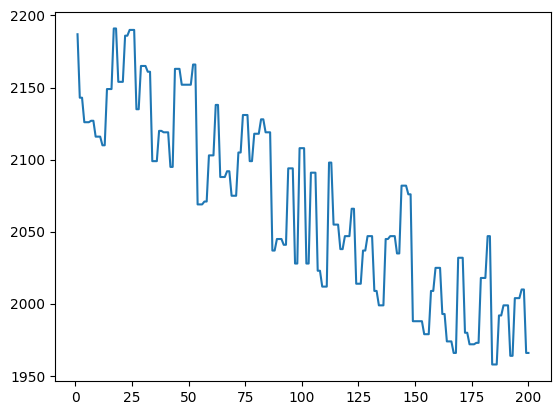

In [ ]:
plt.plot(x_data , y_data)
plt.show()

In [ ]:
# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_data_normalized = scaler_x.fit_transform(x_data.reshape(-1,1))
y_data_normalized = scaler_y.fit_transform(y_data.reshape(-1, 1)).ravel()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data_normalized, y_data_normalized, test_size=0.2, random_state=42)


In [ ]:
# Function to create an LSTM model
def create_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(10, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Function to train and evaluate the LSTM model with early stopping
def train_evaluate_lstm(x_train, y_train, x_test, y_test, epochs=5, batch_size=1):
    input_shape = (x_train.shape[1], 1)
    model = create_lstm_model(input_shape)

    # Implement early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),
              callbacks=[early_stopping])

    y_pred = model.predict(x_test, batch_size=1, verbose=0)
    mse = mean_squared_error(y_test, y_pred.squeeze())
    return mse

In [ ]:
# PSO Objective Function
def objective_function(params, x_train, y_train, x_test, y_test):
    epochs, batch_size = params
    mse = train_evaluate_lstm(x_train, y_train, x_test, y_test, epochs=int(epochs), batch_size=int(batch_size))
    return mse

In [ ]:

# PSO Optimization
lb = [1, 1]  # Lower bounds for epochs and batch_size
ub = [1.5, 1.5]  # Upper bounds for epochs and batch_size

# PSO optimization using the objective function and bounds
best_params, _ = pso(objective_function, lb, ub, args=(x_train, y_train, x_test, y_test))

# Use the best parameters to train the final LSTM model with early stopping
best_epochs, best_batch_size = best_params
final_lstm_model = create_lstm_model((x_train.shape[1], 1))
final_lstm_model.fit(x_train, y_train, epochs=int(best_epochs), batch_size=int(best_batch_size), verbose=1,
                     validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


426/426 [==============================] - 5s 6ms/step - loss: 0.0298 - val_loss: 0.0112


In [ ]:
# Function to create an MLP model
def create_mlp_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(50, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Train and evaluate the MLP model
mlp_model = create_mlp_model(x_train.shape[1])
mlp_model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1)


Epoch 1/100
20/20 [==============================] - 1s 2ms/step - loss: 0.2263
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1760
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1565
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1411
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1268
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1134
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1008
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0882
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0766
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 11/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 12/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0479
Epoch 13/100
20/20 [=================

In [ ]:
# Example: Predict y for a specific x value using the trained models
x_input = np.array([[10]])  # Replace with the desired value of x
x_input_normalized = scaler_x.transform(x_input)
y_lstm_pred_normalized = final_lstm_model.predict(x_input_normalized.reshape(1, 1, 1))[0, 0]
y_lstm_pred = scaler_y.inverse_transform([[y_lstm_pred_normalized]])[0, 0]

y_mlp_pred_normalized = mlp_model.predict(x_input_normalized)[0, 0]
y_mlp_pred = scaler_y.inverse_transform([[y_mlp_pred_normalized]])[0, 0]

print(f'For x={x_input[0, 0]}:')
print(f'LSTM Predicted y: {y_lstm_pred}')
print(f'MLP Predicted y: {y_mlp_pred}')

1/1 [==============================] - 0s 20ms/step
For x=10:
LSTM Predicted y: 2142.9568712711334
MLP Predicted y: 2142.9568712711334
